In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from collections import defaultdict
from matplotlib import pyplot as plt
from os import path

colors = viz.plotting_style()
lin_colors = colors.values()

plt.style.use('style.mpl')

In [2]:
# Schmidt data evidences growth on a variety of carbon sources
ec_conds_df = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
ec_conds_df.head()

mask = ec_conds_df['dataset'] == 'schmidt_2016'
masked = ec_conds_df[mask]

conds2include = 'lb_miller,glycerol_pAA,fructose,glucose,xylose,glycerol,mannose,glucosamine,succinate,fumarate,pyruvate,acetate,galactose'.split(',')
conds2include =  {c: c for c in conds2include}
conds2include['lb_miller'] = 'LB'
conds2include['glycerol_pAA'] = 'glycerol+AA'

masked = masked[masked.condition.isin(conds2include)].copy()
masked['label'] = masked.condition.map(conds2include)

schmidt_lambda4plotting = masked.sort_values('growth_rate_hr', ascending=False)


In [54]:
# Manually curated collection of fast growers
fast_growers_df = pd.read_csv('../data/physiology/fastest_growers.csv')

# Chemostat example. Maximum growth rate exists.
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Metabolic modes of E. coli
coli_modes_df = pd.read_excel('../data/physiology/coli_metabolic_modes.xlsx', index_col=0)

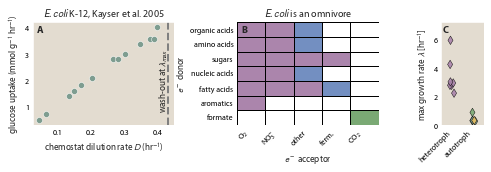

In [65]:
fig, axs = plt.subplots(ncols=3, figsize=(7, 2.5), gridspec_kw={'width_ratios': [1, 1, 0.3]})

plt.sca(axs[0])
sns.scatterplot(data=kayser_chemostat_df, x='D_per_h', y='r_glucose_mmol_g_h', color=colors['dark_green'])
plt.ylabel('glucose uptake (mmol g$^{-1}$ hr$^{-1}$)')
#plt.ylabel('glucose uptake (mmol g$^{-1}$ hr$^{-1}$)', color=colors['dark_green'])
plt.xlabel('chemostat dilution rate $D$ (hr$^{-1}$)')
#plt.ylim(0, 8.7)

plt.axvline(0.43, color='grey', ls='--')
plt.text(0.417, 2, 'wash-out at $\lambda_{max}$', va='center', ha='center', rotation=90, fontsize=9)
plt.title('$E. coli$ K-12, Kayser et al. 2005')

#plt.twinx()
#sns.scatterplot(data=kayser_chemostat_df, x='D_per_h', y='r_o2_mmol_g_h', color=colors['dark_blue'])
#plt.ylabel('O$_2$ uptake (mmol g$^{-1}$ hr$^{-1}$)', color=colors['dark_blue'])
#plt.ylim(0, 8.7)

plt.sca(axs[1])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('$e^-$ donor')
plt.xlabel('$e^-$ acceptor')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.title('$E. coli$ is an omnivore')

# Old plot with Schmidt data
#sns.barplot(data=schmidt_lambda4plotting, x='condition', y='growth_rate_hr', color=colors['blue'])
#xs = np.arange(schmidt_lambda4plotting.label.size)
#plt.xticks(xs, schmidt_lambda4plotting.label, rotation=45, ha='right', fontsize=9)
#plt.xlabel('')
#plt.ylabel('growth rate $\lambda$ (hr$^{-1}$)')
#plt.title('$E. coli$ BW25113, Schmidt et al. 2016')
#plt.ylim(0, 2.3)

plt.sca(axs[2])

cnames = 'dark_green,purple,yellow,green'.split(',')
pal = [colors[c] for c in cnames]
sns.stripplot(data=fast_growers_df, y='growth_rate_hr',
              x='group', hue='category', marker='d', size=6,
              jitter=0.1, palette=pal, order='heterotroph,autotroph'.split(','),
              alpha=0.9, edgecolor='k', linewidth=0.5)
plt.xlabel('')
plt.legend().set_visible(False)
plt.ylabel('max growth rate $\lambda$ [hr$^{-1}$]')
plt.xticks(ha='right', rotation=45)
plt.ylim(0, 7.2)

for label, ax in zip('ABC', axs):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')

plt.tight_layout(w_pad=0.05)
plt.savefig('../output/coli_stylized_facts.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

In [5]:
from linear_opt.lin_metabolism import MW_C_ATOM
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

# Approximate concentrations and ratios for plotting
# Based on Bennett et al. 2009 measurements in E. coli
DEFAULT_ATP = 1.4e-6
DEFAULT_NADH = 1.2e-7
DEFAULT_RE = 10
DEFAULT_RA = 0.3

model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

In [6]:
# Here is a model that has no homeostasis (phi_H <= 0),
# no maintenance (ATP_maint = 0), but can alter biomass
# composition through phi_O. We set a maximum lambda
# so that we can run the model over a range of lambda values.
lambdas = np.arange(0.1, 4, 0.01)
results = []

for lam_val in lambdas:
    # Make fresh parameters with a new max_lambda_hr
    params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, 
                                 max_lambda_hr=lam_val, max_phi_H=0,
                                 fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                 fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    p = params.copy()
    p.max_lambda_hr = lam_val

    # Optimize the growth rate given the parameters
    opt, opt_prob = lam.maximize_growth_rate(params)

    d = lam.results_as_dict(opt_prob, params)
    results.append(d)

phi_df = pd.DataFrame(results)
phi_df['expected_Jana'] = phi_df['anabolism_gamma']*phi_df['anabolism_phi']
phi_df['expected_lambda'] = MW_C_ATOM*3600*phi_df['expected_Jana']
phi_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,...,opt.rate_law_name,opt.rate_law_order,analytic_lambda_zo,analytic_lambda_max_zo,S6_lb_zo,S6_ub_zo,ZCorg_lb_zo,ZCorg_ub_zo,expected_Jana,expected_lambda
0,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,ZeroOrder,0,0.10,0.10,0.15001,-1.200263,-0.30002,1.499883,0.000002,0.10
1,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,ZeroOrder,0,0.11,0.11,0.15001,-1.200263,-0.30002,1.499883,0.000003,0.11
2,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,ZeroOrder,0,0.12,0.12,0.15001,-1.200263,-0.30002,1.499883,0.000003,0.12
3,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,ZeroOrder,0,0.13,0.13,0.15001,-1.200263,-0.30002,1.499883,0.000003,0.13
4,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,ZeroOrder,0,0.14,0.14,0.15001,-1.200263,-0.30002,1.499883,0.000003,0.14


In [7]:
# Sweep a range of biomass ZC values
ZCBs = np.arange(-3, 3.01, 0.05)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for z in ZCBs:
    # Test with and without ATP homeostasis -- first with
    ref_lam = lmm.copy()
    ref_lam.set_ZCB(z)
    # Note we are fixing phi_O here to highlight the contribution of phi_H
    params = GrowthRateOptParams(phi_O=0.4, do_dilution=True,
                                 fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                 fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    m, opt_p = ref_lam.maximize_growth_rate(params)
    d = ref_lam.results_as_dict(opt_p, params)
    results.append(d)

    # Now without -- seting max_phi_H = 0
    params_nh = GrowthRateOptParams(phi_O=0.4, do_dilution=True, max_phi_H=0,
                                    fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                    fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    m, opt_p = ref_lam.maximize_growth_rate(params_nh)
    d = ref_lam.results_as_dict(opt_p, params_nh)
    results.append(d)

S6_sensitivity_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [8]:
# Sweep a range of biomass ZC values
ZCorgs = np.arange(-3, 3.01, 0.05)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for z in ZCorgs:
    # Test with and without ATP homeostasis -- first with
    ref_lam = lmm.copy()
    ref_lam.set_ZCorg(z)
    # Note we are fixing phi_O here to highlight the contribution of phi_H
    params = GrowthRateOptParams(phi_O=0.4, do_dilution=True,
                                 fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                 fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    m, opt_p = ref_lam.maximize_growth_rate(params)
    d = ref_lam.results_as_dict(opt_p, params)
    results.append(d)

    # Now without -- seting max_phi_H = 0
    params_nh = GrowthRateOptParams(phi_O=0.4, do_dilution=True, max_phi_H=0,
                                    fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                    fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    m, opt_p = ref_lam.maximize_growth_rate(params_nh)
    d = ref_lam.results_as_dict(opt_p, params_nh)
    results.append(d)

zcorg_sensitivity_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [9]:
auto_model_dir = '../models/linear/autotrophy/'
auto_m_fname = path.join(auto_model_dir, 'glucose_auto_molecular_props.csv')
auto_S_fname = path.join(auto_model_dir, 'glucose_auto_stoich_matrix.csv')

# models of auto and heterotrophy for comparison
auto_lam = LinearMetabolicModel.FromFiles(auto_m_fname, auto_S_fname)
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

In [10]:
pmasses = np.logspace(2, 5, 50)

auto_results = []
results = []
for pmass in pmasses:
    # Set the process masses
    auto_lam.set_process_masses(pmass)
    lam.set_process_masses(pmass)
    
    # Make fresh parameters with a new max_lambda_hr
    params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, 
                                 fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                 fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)

    # Optimizing the heterotrophic growth rate given the parameters
    opt, opt_prob = lam.maximize_growth_rate(params)
    d = lam.results_as_dict(opt_prob, params)
    results.append(d)

    # Optimize the autotrophic growth rate given the parameters
    auto_opt, auto_opt_prob = auto_lam.maximize_growth_rate(params)
    d = auto_lam.results_as_dict(auto_opt_prob, params)
    auto_results.append(d)

auto_gamma_df = pd.DataFrame(auto_results)
gamma_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


estimated lambda_max: 2.592
actual lambda_max: 2.2870426324525845


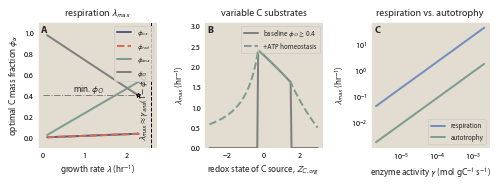

In [25]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7, 2.7))

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

plt.sca(axs[0])

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)
plt.text(1.1, min_phi_O+0.03, r'min. $\phi_O$', ha='center', fontsize=9)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['dark_green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{ox}$',
    reduction=r'$\phi_{red}$',
    anabolism=r'$\phi_{ana}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['purple'], edgecolor='k', marker='*', zorder=10, s=20)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
plt.text(est_lambda_max-0.02, 0.3, r'$\lambda_{max} \approx \gamma_{ana}(1-\phi_O)$', ha='right', va='center', rotation=90, fontsize=9)
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal C mass fraction $\phi_\alpha$')   
plt.legend(loc=1)
plt.ylim(-0.1, 1.1)

plt.sca(axs[1])
phi_H_included = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == False]
no_phi_H = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey',
         label=r'baseline $\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr,
         color=colors['dark_green'], ls='--',
         label=r'+ATP homeostasis', zorder=10)

plt.legend(loc=1)
plt.ylim(0, 3.1)
plt.xlabel('redox state of C source, $Z_{C,org}$')
plt.ylabel(r'$\lambda_{max}$ (hr$^{-1}$)')

plt.sca(axs[2])
plt.xscale('log')
plt.yscale('log')
plt.plot(gamma_df.anabolism_gamma, gamma_df.lambda_hr,
         color=colors['blue'], label='respiration')
plt.plot(auto_gamma_df.anabolism_gamma, auto_gamma_df.lambda_hr,
         color=colors['dark_green'], label='autotrophy')
plt.xlabel('enzyme activity $\gamma$ (mol gC$^{-1}$ s$^{-1}$)')
plt.ylabel(r'$\lambda_{max}$ (hr$^{-1}$)')
plt.legend(loc=4)

titles = 'respiration $\lambda_{max}$,variable C substrates,respiration vs. autotrophy'.split(',')
for title, label, ax in zip(titles, 'ABC', axs):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_title(title)
    
plt.tight_layout()
plt.savefig('../output/model_growth_limits.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
# Sweep a range of C-source ZCred values for a few
# different respiratory ATP yields, S4
ZCorgs = np.arange(-3, 3.01, 0.05)
S4vals = np.arange(0.2, 1.21, 0.2)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for S4 in S4vals:
    for z in ZCorgs:
        # Test with and without ATP homeostasis -- first with
        ref_lam = lmm.copy()
        ref_lam.set_ZCorg(z)
        ref_lam.set_ATP_yield('reduction', S4)
        # Note we are fixing phi_O here to highlight the contribution of phi_H
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                     fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params)
        d = ref_lam.results_as_dict(opt_p, params)
        results.append(d)

        # Now without -- seting max_phi_H = 0
        params_nh = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, max_phi_H=0,
                                        fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                        fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params_nh)
        d = ref_lam.results_as_dict(opt_p, params_nh)
        results.append(d)

zcorg_sensitivity_var_s4 = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [13]:
# Sweep a range of C-source ZCred values for a few
# different oxidative ATP yields, S3
ZCorgs = np.arange(-3, 3.01, 0.05)
S3vals = np.arange(-0.1, 0.91, 0.2)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for S3 in S3vals:
    for z in ZCorgs:
        # Test with and without ATP homeostasis -- first with
        ref_lam = lmm.copy()
        ref_lam.set_ZCorg(z)
        ref_lam.set_ATP_yield('oxidation', S3)
        # Note we are fixing phi_O here to highlight the contribution of phi_H
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                     fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params)
        d = ref_lam.results_as_dict(opt_p, params)
        results.append(d)

        # Now without -- seting max_phi_H = 0
        params_nh = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, max_phi_H=0,
                                        fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                        fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params_nh)
        d = ref_lam.results_as_dict(opt_p, params_nh)
        results.append(d)

zcorg_sensitivity_var_s3 = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [70]:
# Sweep a range of C-source ZCred values for a few
# different ZCB values
ZCorgs = np.arange(-3, 3.01, 0.05)
ZCBs = np.arange(-0.5, 0.51, 0.1)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for zcb in ZCBs:
    for zcorg in ZCorgs:
        # Test with and without ATP homeostasis -- first with
        ref_lam = lmm.copy()
        ref_lam.set_ZCorg(zcorg)
        ref_lam.set_ZCB(zcb)
        # Note we are fixing phi_O here to highlight the contribution of phi_H
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                     fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params)
        d = ref_lam.results_as_dict(opt_p, params)
        results.append(d)

        # Now without -- seting max_phi_H = 0
        params_nh = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, max_phi_H=0,
                                        fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                        fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params_nh)
        d = ref_lam.results_as_dict(opt_p, params_nh)
        results.append(d)

zcorg_sensitivity_var_zcb = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


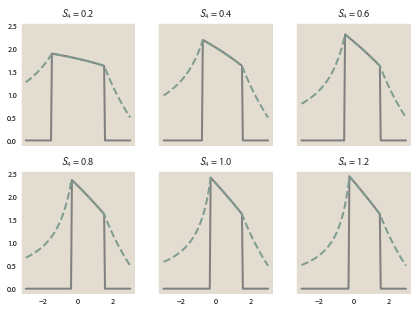

In [71]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()

for i, S4 in enumerate(S4vals):
    mask = zcorg_sensitivity_var_s4['S4'] == S4
    masked = zcorg_sensitivity_var_s4[mask]

    phi_H_included = masked[
       masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]

    plt.sca(flat_axs[i])
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey')
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=colors['dark_green'], ls='--')
    
    plt.title('$S_4$ = {0:.1f}'.format(S4))

plt.show()


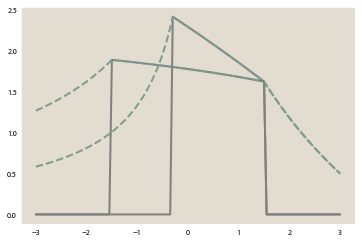

In [72]:
lowest = zcorg_sensitivity_var_s4[zcorg_sensitivity_var_s4['S4'] == 0.2]
highest = zcorg_sensitivity_var_s4[zcorg_sensitivity_var_s4['S4'] == 1]


phi_H_included = lowest[
    lowest['opt.max_phi_H_set'] == False]
no_phi_H = lowest[
    lowest['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey')
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=colors['dark_green'], ls='--')

phi_H_included = highest[
    highest['opt.max_phi_H_set'] == False]
no_phi_H = highest[
    highest['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey')
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=colors['dark_green'], ls='--')

plt.show()

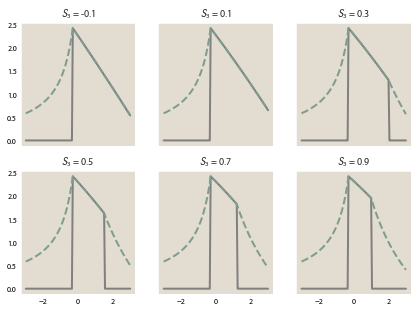

In [73]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()

for i, S3 in enumerate(S3vals):
    mask = zcorg_sensitivity_var_s3['S3'] == S3
    masked = zcorg_sensitivity_var_s3[mask]

    phi_H_included = masked[
       masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]

    plt.sca(flat_axs[i])
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey')
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=colors['dark_green'], ls='--')
    
    plt.title('$S_3$ = {0:.1f}'.format(S3))

plt.show()


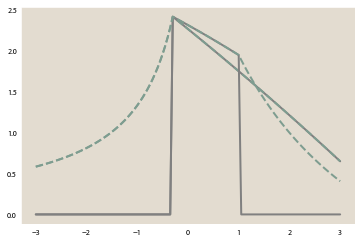

In [74]:
lowest = zcorg_sensitivity_var_s3[zcorg_sensitivity_var_s3['S3'] == 0.1]
highest = zcorg_sensitivity_var_s3[zcorg_sensitivity_var_s3['S3'] == 0.9]

phi_H_included = lowest[
    lowest['opt.max_phi_H_set'] == False]
no_phi_H = lowest[
    lowest['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey')
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=colors['dark_green'], ls='--')

phi_H_included = highest[
    highest['opt.max_phi_H_set'] == False]
no_phi_H = highest[
    highest['opt.max_phi_H_set'] == True]
plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey')
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=colors['dark_green'], ls='--')

plt.show()

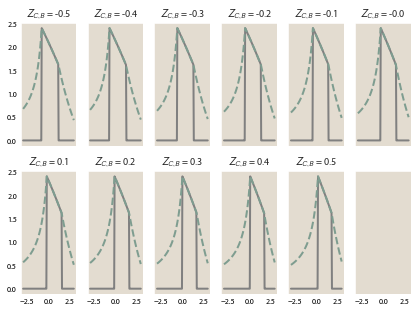

In [75]:
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(7, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()

for i, zcb in enumerate(ZCBs):
    mask = zcorg_sensitivity_var_zcb['ZCB'] == zcb
    masked = zcorg_sensitivity_var_zcb[mask]

    phi_H_included = masked[
       masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]

    plt.sca(flat_axs[i])
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey')
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=colors['dark_green'], ls='--')
    
    plt.title('$Z_{{C,B}}$ = {0:.1f}'.format(zcb))

plt.show()


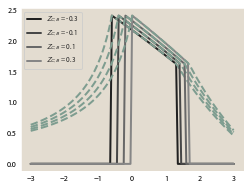

In [84]:
plt.figure(figsize=(4,3))
my_ZCBs = ZCBs[[ 2, 4, 6, 8]]
pal = sns.color_palette('Greys_r', n_colors=2*len(my_ZCBs))
for i, zcb in enumerate(my_ZCBs):
    mask = zcorg_sensitivity_var_zcb['ZCB'] == zcb
    masked = zcorg_sensitivity_var_zcb[mask]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$Z_{{C,B}}$ = {0:.1f}'.format(zcb))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=colors['dark_green'], ls='--')

plt.legend()
plt.savefig('../output/zcb_zcorg.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()